### Load Data

In [1]:
import pandas as pd

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '1.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date")

In [2]:
# Dependant variable
dep_var = 'Orders'     

In [3]:
df

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV
Date,,,,,,,
2006-01-01,1124,100.83240,0.807265,8.3,3.280000,1.170000,20177
2006-02-01,1079,100.80160,0.901804,8.0,3.440000,1.186667,12845
2006-03-01,1210,100.60100,0.899101,7.7,3.620000,1.180000,15163
2006-04-01,1147,100.48250,1.297405,7.7,3.880000,1.243333,13472
2006-05-01,1001,100.56730,1.701702,7.9,3.940000,1.260000,16516
...,...,...,...,...,...,...,...
2022-08-01,254,94.58021,7.616082,7.2,1.624904,2.153333,8163
2022-09-01,228,94.10754,8.119296,7.3,2.420836,2.133333,7867
2022-10-01,188,93.96142,8.310766,6.4,2.894486,2.136667,7132


### Split Data

In [4]:
steps = 36  # 36 months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=168)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


In [5]:
# df.asfreq('MS')
# train.asfreq('MS')
# test.asfreq('MS')

### Scoring function

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf
import math
import numpy as np
import matplotlib as plt

metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, forecast, actual):
    
    mae = np.mean(np.abs(forecast - actual))                                    # MAE
    mse = mean_squared_error(actual, forecast)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                       # RMSE (Root Mean Squared Error)    
    r2 = r2_score(actual, forecast)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)*100)                # MAPE        
    accuracy = 100 - mape                                                       # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']              

### ARIMA

In [23]:
import pmdarima as pm

#Standard ARIMA Model
ARIMA_model = pm.auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2237.797, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2657.150, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2297.432, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2524.298, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2238.593, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2238.653, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2441.767, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2267.097, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2236.231, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2258.090, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2247.079, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2244.209, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2245.608, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

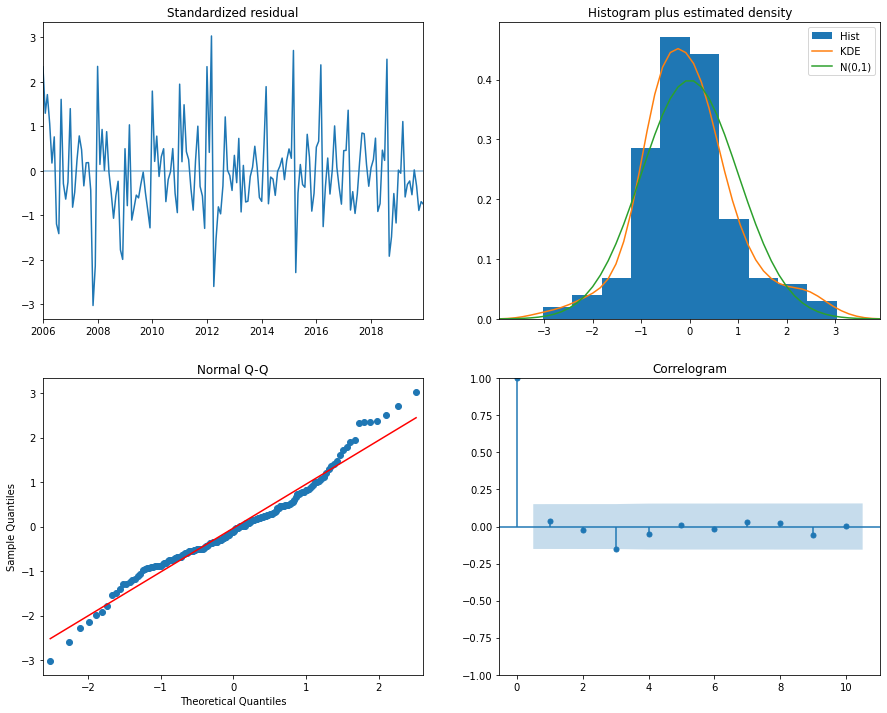

In [24]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [25]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1114.115
Date:                Sun, 12 Feb 2023   AIC                           2236.231
Time:                        21:27:20   BIC                           2248.727
Sample:                    01-01-2006   HQIC                          2241.302
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.6039     33.117      1.709      0.087      -8.305     121.513
ar.L1          0.9093      0.050     18.286      0.000       0.812       1.007
ma.L1         -0.6712      0.075     -8.930      0.000      -0.819      -0.524
sigma2       3.45e+04   3276.614     10.530      0.000    2.81e+04    4.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                12.14
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                             0.38
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


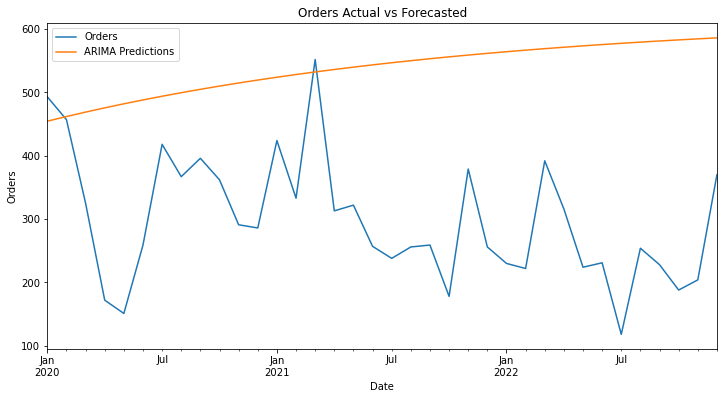

In [26]:
import statsmodels.api as sm

# Build and fir the model
model = sm.tsa.arima.ARIMA(train[dep_var],order=(1,0,1)).fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [27]:
forecast_accuracy('ARIMA', predictions, test[dep_var])

In [28]:
metrics

,ARIMA
Mean Absolute Error,241.982096
Mean Squared Error,71111.856518
Root Mean Squared Error,266.668064
R^2,-6.427178
Mean Absolute Percentage Error,104.200621
Accuracy,-4.200621


### SARIMA

In [29]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1999.944, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2084.475, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2039.583, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2002.150, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2043.561, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2001.868, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2001.830, Time=1.49 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2017.834, Time=0.32 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2022.606, Time=0.29 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2001.822, Time=0.73 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2001.860, Time=0.67 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2041.516, Time=0.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1999.922, Time=0.45 sec
 ARIMA(0,1,2)(0,1,0)[12]

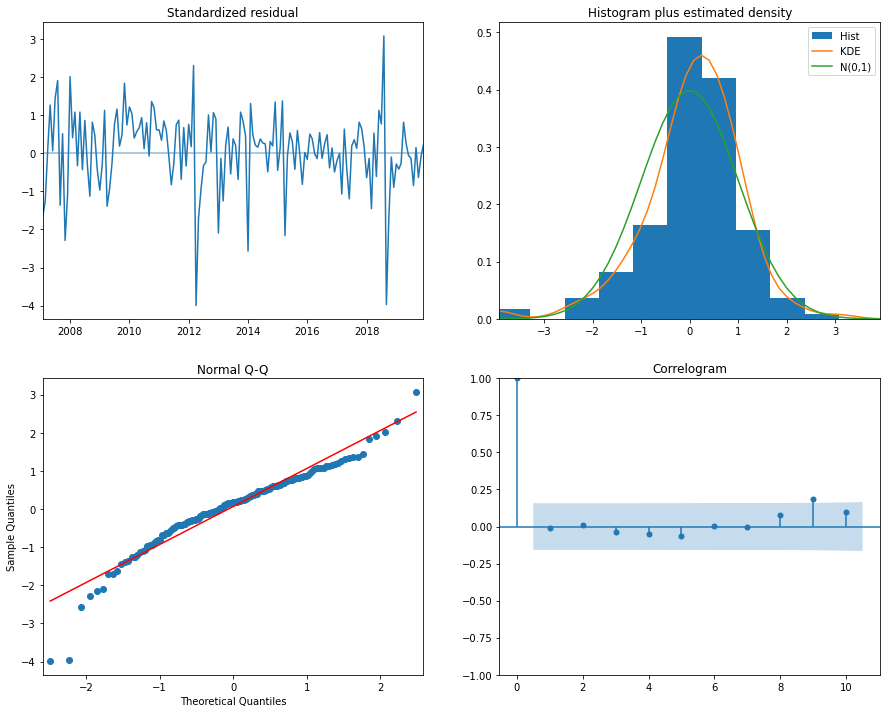

In [30]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [31]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -995.961
Date:                              Sun, 12 Feb 2023   AIC                           1999.922
Time:                                      21:27:44   BIC                           2012.095
Sample:                                  01-01-2006   HQIC                          2004.866
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5741      0.059     -9.672      0.000      -0.690      -0.458
ma.L2         -0.1540      0.074     -2.087      0.037      -0.299      -0.009
ma.S.L12      -0.6527      0.094     -6.949      0.000      -0.837      -0.469
sigma2      2.137e+04   2073.417     10.305      0.000    1.73e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.81
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.91
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


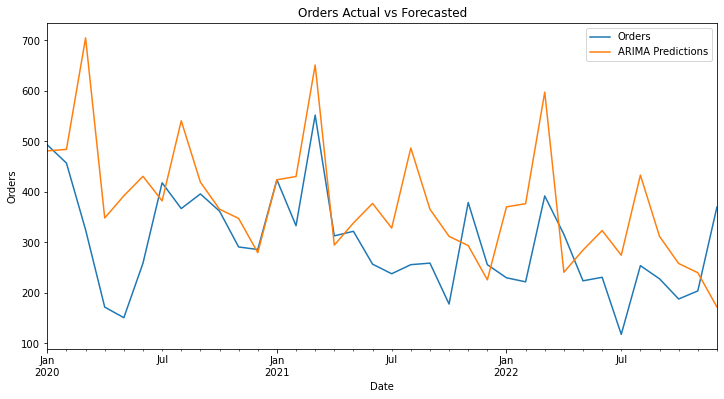

In [32]:
import statsmodels.api as sm

# Build model
model = sm.tsa.arima.ARIMA(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12))
# Fit model
result = model.fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [38]:
forecast_accuracy('SARIMA', predictions, test[dep_var])

In [39]:
metrics

,ARIMA,SARIMA
Mean Absolute Error,241.982096,105.274896
Mean Squared Error,71111.856518,17932.820931
Root Mean Squared Error,266.668064,133.913483
R^2,-6.427178,-0.872968
Mean Absolute Percentage Error,104.200621,42.919213
Accuracy,-4.200621,57.080787


### SARIMAX

In [40]:
# SARIMAX = SARIMA with exogenous variable
exo_var = 'TIV'
SARIMAX_model = pm.auto_arima(train[dep_var], exogenous=train[exo_var],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1999.944, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2084.475, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2039.583, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2002.150, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2043.561, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2001.868, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2001.830, Time=1.48 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2017.834, Time=0.33 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2022.606, Time=0.30 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2001.822, Time=0.74 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2001.860, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2041.516, Time=0.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1999.922, Time=0.45 sec
 ARIMA(0,1,2)(0,1,0)[12]

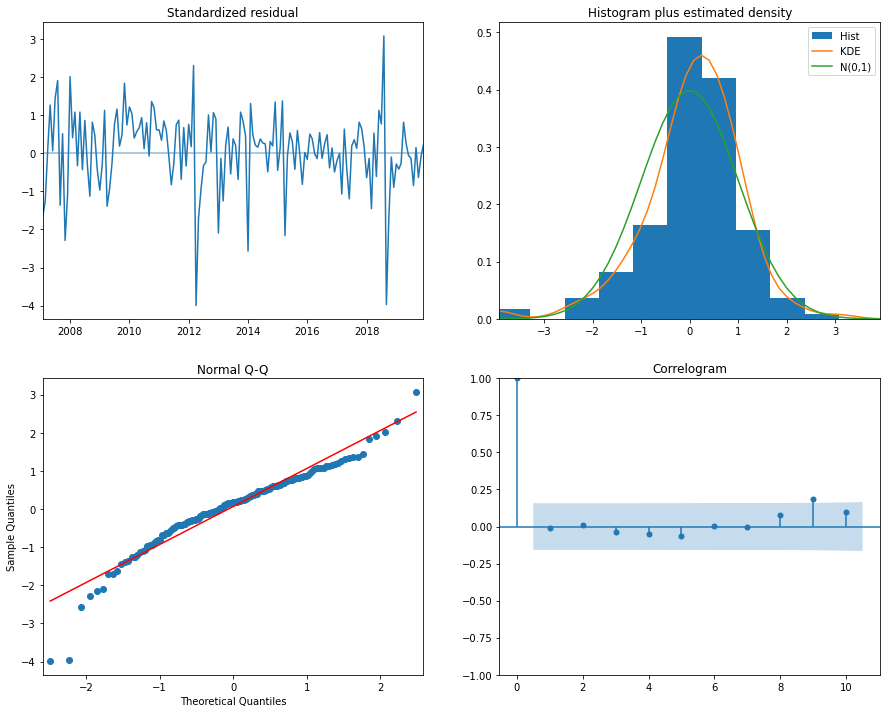

In [41]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [42]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -995.961
Date:                              Sun, 12 Feb 2023   AIC                           1999.922
Time:                                      21:29:02   BIC                           2012.095
Sample:                                  01-01-2006   HQIC                          2004.866
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5741      0.059     -9.672      0.000      -0.690      -0.458
ma.L2         -0.1540      0.074     -2.087      0.037      -0.299      -0.009
ma.S.L12      -0.6527      0.094     -6.949      0.000      -0.837      -0.469
sigma2      2.137e+04   2073.417     10.305      0.000    1.73e+04    2.54e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                76.81
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.91
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


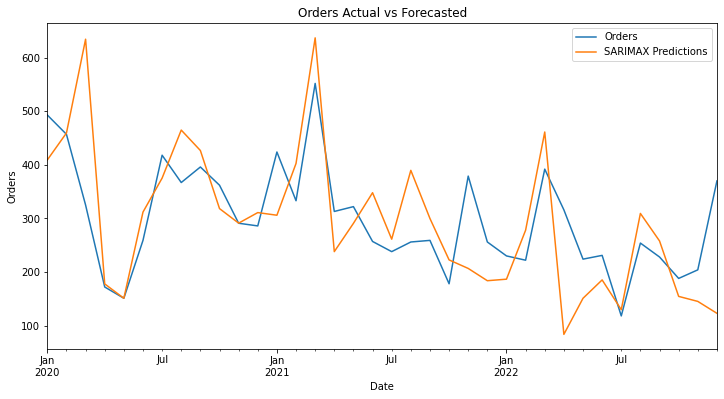

In [43]:
# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12),exog = train[exo_var])

# Fit model
result = model.fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels').rename('SARIMAX Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [44]:
forecast_accuracy('SARIMAX with ' + exo_var , predictions, test[dep_var])

### Summary

In [45]:
metrics

,ARIMA,SARIMA,SARIMAX with TIV
Mean Absolute Error,241.982096,105.274896,72.445055
Mean Squared Error,71111.856518,17932.820931,9986.288122
Root Mean Squared Error,266.668064,133.913483,99.931417
R^2,-6.427178,-0.872968,-0.043004
Mean Absolute Percentage Error,104.200621,42.919213,23.829404
Accuracy,-4.200621,57.080787,76.170596
